# Descarga y exploración del corpus

In [2]:
# Import all the libraries 
import pandas as pd 
import numpy as np 
import gzip
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import string


In [ ]:
# import the JSON file into a dataframe after opening the gzipped file
with gzip.open('/content/Video_Games.json.gz', 'rb') as f:
  df = pd.read_json(f, lines=True)

# To avoid the risk of class imbalance, we will randomly sample 5000 data samples for each value (1,2,4,5)
# Filter the data based on the desired values in the 'overall' column
filtered_df = df[df['overall'].isin([1, 2, 4, 5])]

# Sample the same number of rows for each value
num_samples = 5000
sampled_df_1 = filtered_df[filtered_df['overall'] == 1].sample(n=num_samples)
sampled_df_2 = filtered_df[filtered_df['overall'] == 2].sample(n=num_samples)
sampled_df_4 = filtered_df[filtered_df['overall'] == 4].sample(n=num_samples)
sampled_df_5 = filtered_df[filtered_df['overall'] == 5].sample(n=num_samples)

# Concatenate the resulting dataframes
result_df = pd.concat([sampled_df_1, sampled_df_2, sampled_df_4, sampled_df_5])

# Export the sampled dataframe to a new CSV file for easier access for the next iteration
result_df.to_csv('sampled_data_file.csv', index=False)

In [3]:
df = pd.read_csv('/content/sampled_data_file.csv')

In [ ]:
# Checking the first rows
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,4,True,"01 20, 2012",A2345DQDQ6VZ1F,B0057PERTS,Van,This is a pretty good game! My daughter loves ...,FUN FUN!!!,1327017600,NaN,{'Format:': ' Video Game'},NaN
1,5,False,"11 9, 2009",AJ92DU5T9WUJ3,B001TOMR0M,byteman,"First, let's clear one thing up and remember t...",Great addition the franchise; includes some ma...,1257724800,33.0,{'Platform:': ' PlayStation 3'},NaN
2,1,True,"03 24, 2011",A3U90ZCN54JSG7,B0015LMOTS,Ari,The blue button stopped working very quickly. ...,Broke very quickly,1300924800,2.0,NaN,NaN
3,2,False,"09 4, 2006",AIUXSQF5L5NRH,B000E0L424,PSP Player,I have never played any games in the SC series...,Very disappointing game,1157328000,2.0,NaN,NaN
4,2,True,"11 11, 2016",A27HZ2C0L6GP3D,B0050SXLQC,Gustavo Len,this is a no no,Two Stars,1478822400,NaN,{'Format:': ' Video Game'},NaN


#Cardinalidad del vocabulario

In [ ]:
# Create a df with only the reviews
text_df = df['reviewText']

# Tokenization of the text 
nltk.download('punkt')

palabras = []
for review in text_df:
    palabras.extend(nltk.word_tokenize(review.lower()))


# Count the frequency of each word 
frecuencia_palabra = {}

for palabra in palabras:
    if palabra not in frecuencia_palabra:
        frecuencia_palabra[palabra] = 1
    else:
        frecuencia_palabra[palabra] += 1

# Sorting the dictionary by frequency
palabras_clasificadas = sorted(frecuencia_palabra.items(), key=lambda x: x[1], reverse=True)

# Calculate the vocabulary cardinality
cardinalidad = len(frecuencia_palabra)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(cardinalidad)

40358


The number of unique words in our corpus is 40 358. 

In [ ]:
# Sorting the dictionary by frequency
palabras_clasificadas = sorted(frecuencia_palabra.items(), key=lambda x: x[1], reverse=True)

# Top 20 most frequent words 
for word, freq in palabras_clasificadas[:20]:
    print(f"{word}: {freq}")

.: 92853
the: 90977
,: 65030
i: 45857
to: 45847
and: 45503
a: 41386
it: 40408
is: 29310
of: 28967
you: 26048
game: 25358
this: 24521
for: 19246
that: 18474
in: 17876
but: 14348
n't: 13843
with: 13375
not: 13323


In [ ]:
# Getting rid of the stopwords and punctuation in the list
nltk.download('stopwords')
stopwords = stopwords.words('english')
pontuación = ['.', ',', '!', '(', ')', "''", ':', "``", '...']

palabras_sin_stopwords =  [(palabra, num) for (palabra, num) in palabras_clasificadas if palabra.lower() not in stopwords]
palabras_sin_pontuación = [(palabra, num) for (palabra,num) in palabras_sin_stopwords if palabra.lower() not in pontuación]

# Top 20 most frequent words 
for word, freq in palabras_sin_pontuación[:20]:
    print(f"{word}: {freq}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


game: 25358
n't: 13843
's: 10939
like: 7450
one: 6931
get: 5895
play: 5658
games: 5481
great: 5143
good: 5073
would: 5068
time: 4420
really: 4143
even: 3673
fun: 3614
much: 3248
?: 3108
well: 3054
first: 2961
work: 2934


#Distribución de reviews por número de estrellas

In [ ]:
# get the distribution of reviews for each star
review_counts = df['overall'].value_counts()
print(review_counts)

4    5000
5    5000
1    5000
2    5000
Name: overall, dtype: int64


Text(0, 0.5, 'Número de reviews')

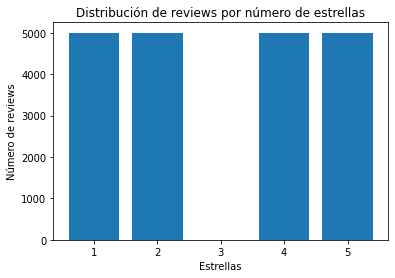

In [ ]:
# Visualization of the distribution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(review_counts.index, review_counts.values)

# set the chart title and axis labels
ax.set_title('Distribución de reviews por número de estrellas')
ax.set_xlabel('Estrellas')
ax.set_ylabel('Número de reviews')

# Nº de reviews positivas y negativas

In [ ]:
# We will consider 1 to 2 to be bad reviews and 4 to 5 to be good 
# count the number of positive and negative reviews
positivas = (df['overall'] >= 4).sum()
negativas = (df['overall'] <= 2).sum()

# print the results
print(f"Nº de reviews positivas: {positivas}")
print(f"Nº de reviews negativas: {negativas}")

Nº de reviews positivas: 10000
Nº de reviews negativas: 10000


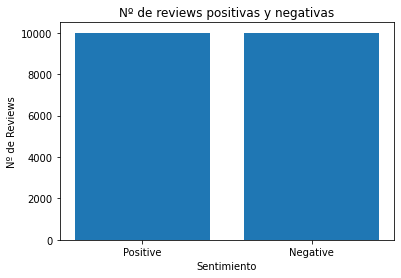

In [ ]:
# Visualization
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(['Positive', 'Negative'], [positivas, negativas])

# set the chart title and axis labels
ax.set_title('Nº de reviews positivas y negativas')
ax.set_xlabel('Sentimiento')
ax.set_ylabel('Nº de Reviews')

# display the chart
plt.show()

# Nubes de palabras

In [ ]:
# concatenate all the reviews into a single string
text = ' '.join(df['reviewText'].fillna('').values)

# create a WordCloud object and generate the word cloud
nubes = WordCloud(width=800, height=800, background_color='white').generate(text)

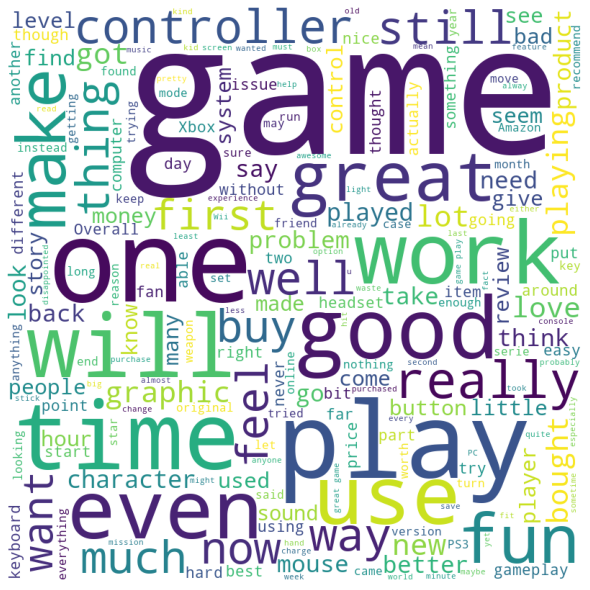

In [ ]:
# Plot the wordcloud
fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(nubes)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Word2Vec

In [ ]:
# Visualización en 2 dimensiones de algunos word embeddings calculados con
# Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

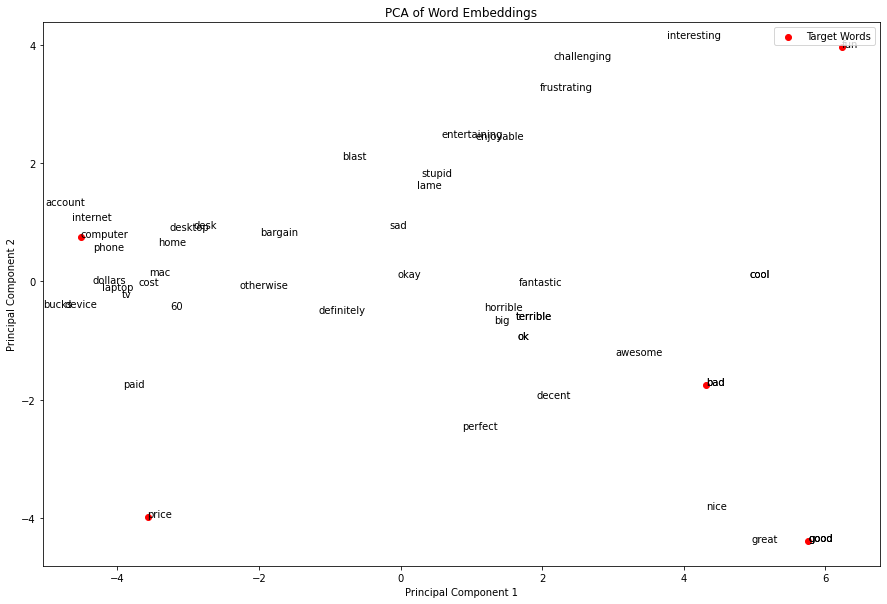

In [ ]:
# concatenate all the reviews into a list of sentences
frases = [str(review).lower().split() for review in df['reviewText'].fillna('').values]
frases_clean = []
for frase in frases:
    # Remove punctuation
    frase_no_punct = [word.translate(str.maketrans('', '', string.punctuation)) for word in frase]
    frases_clean.append(frase_no_punct)

# train a Word2Vec model on the sentences
model = Word2Vec(frases_clean, size=100, window=5, min_count=5, workers=4)

# choose 5 target words
palabra_ob = ['good', 'bad', 'price', 'computer', 'fun']

# compute the top 10 most similar words for each target word
similares = {}
for target in palabra_ob:
    similares[target] = [word for word, _ in model.wv.most_similar(target, topn=10)]

# compute the PCA of the word embeddings for the target words and their similar words
words = palabra_ob + [word for words in similares.values() for word in words]
embeddings = model.wv[words]
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# plot the PCA of the word embeddings
fig, ax = plt.subplots()
ax.scatter(principal_components[:5, 0], principal_components[:5, 1], color='red', label='Target Words')
for i, target in enumerate(palabra_ob):
    ax.annotate(target, (principal_components[i, 0], principal_components[i, 1]))
for i, word in enumerate(words[5:]):
    ax.annotate(word, (principal_components[i+5, 0], principal_components[i+5, 1]))
fig.set_figheight(10)
fig.set_figwidth(15)
ax.set_title('PCA of Word Embeddings')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

# display the plot
plt.show()

In [ ]:
model.wv.most_similar('bad', topn=10)

[('good', 0.7578809857368469),
 ('terrible', 0.6841563582420349),
 ('ok', 0.6589905619621277),
 ('stupid', 0.6549507975578308),
 ('cool', 0.6152364015579224),
 ('horrible', 0.5826631784439087),
 ('lame', 0.5745536684989929),
 ('okay', 0.5705187320709229),
 ('sad', 0.5694661736488342),
 ('big', 0.5585885047912598)]

In [ ]:
model.wv.most_similar('computer', topn=10)

[('laptop', 0.7886862754821777),
 ('phone', 0.7459800243377686),
 ('account', 0.7295117974281311),
 ('mac', 0.7078064680099487),
 ('internet', 0.705141544342041),
 ('tv', 0.6943551301956177),
 ('home', 0.687035083770752),
 ('desktop', 0.6698547601699829),
 ('device', 0.6644770503044128),
 ('desk', 0.6634438633918762)]

In [ ]:
model.wv.most_similar('price', topn=10)

[('cost', 0.6582295298576355),
 ('60', 0.6327255964279175),
 ('paid', 0.6283639669418335),
 ('product', 0.6258845925331116),
 ('definitely', 0.6237350702285767),
 ('dollars', 0.60371333360672),
 ('otherwise', 0.6002202033996582),
 ('bucks', 0.5999205112457275),
 ('headset', 0.581748366355896),
 ('bargain', 0.5804952383041382)]

In [ ]:
model.wv.most_similar('good', topn=10)

[('great', 0.7874796986579895),
 ('bad', 0.7578809857368469),
 ('decent', 0.7450224757194519),
 ('cool', 0.7283525466918945),
 ('nice', 0.7167540192604065),
 ('ok', 0.7150230407714844),
 ('perfect', 0.7052330374717712),
 ('awesome', 0.6834490299224854),
 ('fantastic', 0.6630549430847168),
 ('terrible', 0.6509833335876465)]

In [ ]:
model.wv.most_similar('fun', topn=10)

[('challenging', 0.662165105342865),
 ('boring', 0.6500527262687683),
 ('interesting', 0.6258643865585327),
 ('blast', 0.6002776622772217),
 ('enjoyable', 0.5938607454299927),
 ('entertaining', 0.5758202075958252),
 ('frustrating', 0.570245087146759),
 ('story', 0.5692636966705322),
 ('game', 0.5686339139938354),
 ('good', 0.5685951113700867)]

# Average size of the review

Average number of words per review: 84.81
Maximum number of words in a review: 4142
Minimum number of words in a review: 1


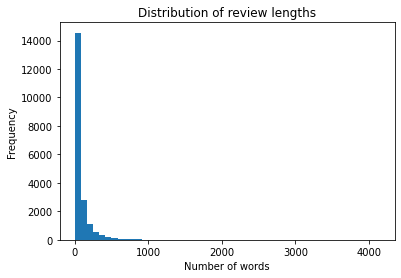

In [5]:
# Define a function to count the number of words in a text string
def count_words(text):
    return len(text.split())

# Apply the count_words function to each row of the 'reviewText' column
df['word_count'] = df['reviewText'].apply(count_words)

# Calculate the average, maximum, and minimum number of words in the 'reviewText' column
avg_word_count = df['word_count'].mean()
max_word_count = df['word_count'].max()
min_word_count = df['word_count'].min()

# Print the results
print("Average number of words per review: {:.2f}".format(avg_word_count))
print("Maximum number of words in a review: {}".format(max_word_count))
print("Minimum number of words in a review: {}".format(min_word_count))

# Create a histogram of the word counts
plt.hist(df['word_count'], bins=50)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Distribution of review lengths')
plt.show()

# Conclusiones de la exploración

After analyzing a corpus of 20,000 video game reviews from Amazon, it was found that the most frequently used words were "game", "like", "great", "one", "games", "play", "good", "get", "would", "really", "fun", "time", "even", "much", "well", "also", "new", and "first", with a total of 40,358 unique words in the corpus. The average, maximum, and minimum number of words per review were 84.81, 4142, and 1, respectively.This indicates that, on average, each review is relatively long, with almost 85 words per review. This could suggest that the reviews contain a lot of details or opinions that could be useful for sentiment analysis, but it could also mean that some reviews are overly verbose or repetitive.

Additionally, to avoid the pitfall of class imbalance in sentiment analysis and because this very large dataset was allowing us to do that, we randomly sampled 5000 reviews from each class. This ensured that our analysis was not biased towards the majority class and allowed us to make more accurate generalizations about the sentiment expressed in the reviews.

In terms of word similarity using Word2Vec, I found that the word "good" is most similar to "great", "decent", and "cool", while the word "bad" is most similar to "good", "okay", and "big". Interestingly, the word "fun" is most similar to "challenging", "enjoyable", and "blast".

Overall, these findings suggest that the majority of reviewers are generally positive about their experiences with video games. The most common words used in their reviews reflect this positivity, with words like "great" and "fun" appearing frequently. The results of the Word2Vec analysis suggest that some words that might be considered opposites, such as "good" and "bad", are actually used in similar contexts in these reviews. This could be due to the subjective nature of reviews, where a "bad" experience for one person may not necessarily be the same for another.